# First import pytorch requirements

Usually you important everything at the top of your python file or jupyter notebook but I have explanations as we go through this and only import the minimum requirements.

In [1]:
# pytorch library
import torch

# Load MNIST and verify

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Number of training examples: 60000
Each with one image and one ground truth (gt) label: 2
One image and one label (number)
<PIL.Image.Image image mode=L size=28x28 at 0x7F93C4E35CA0>
5
Lets take a look at the image size
(28, 28)
Lastly let's verify that the image and gt label match


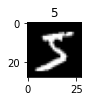

In [2]:
# torchvision is a computer vision library that pytorch created for common datasets
# https://pytorch.org/docs/stable/torchvision
import torchvision
# import MNIST loader
from torchvision.datasets import MNIST

# https://pytorch.org/docs/stable/torchvision/datasets.html#mnist
# torchvision.datasets.MNIST(root, train=True, transform=None, target_transform=None, download=False)
mnist_train_data = MNIST('data', train=True, download=True)

print("Number of training examples:", len(mnist_train_data))
print("Each with one image and one ground truth (gt) label:", len(mnist_train_data[0]))

print("One image and one label (number)")
print(mnist_train_data[0][0])
print(mnist_train_data[0][1])

print("Lets take a look at the image size")
print(mnist_train_data[0][0].size)

print("Lastly let's verify that the image and gt label match")
import matplotlib.pyplot as plt

img, label = mnist_train_data[0]

fig = plt.figure(figsize=(1,1))
ax1 = fig.add_subplot(1,1,1)
plt.title(label)
ax1.imshow(img, cmap="gray")

# Define data augmentations and training data loader

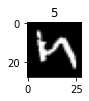

In [3]:
# import data transforms
# https://pytorch.org/docs/stable/torchvision/transforms.html
# Take note of transforms.ToPILImage and transforms.ToTensor
import torchvision.transforms as transforms

# Data augmentation is a technique where we transform the examples randomly in a way
# that doesn't change its label, which artificially augments the amount of data we have.

# See here for a list of augmentations available: https://pytorch.org/vision/stable/transforms.html
# What transforms make sense for this data?
# - ColorJitter? No, the image is in grayscale
# - RandomFlip? No, it won't look like a number anymore
# - RandomRotation? Yes, numbers can be slightly slanted
# - Normalize? Yes, you should always normalize your data

# Use Compose method to create a sequential pipeline of transformations
# Note that most transforms expect a PIL image, then ToTensor converts it to
# PyTorch tensor convention and Normalize expects a tensor
mnist_train_tf = transforms.Compose([
    transforms.RandomRotation([-10, 10]),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # Supplied with dataset (mean, std)
])

# Let's test out the transform (without ToTensor)
img_tfed = transforms.RandomRotation([90, 90])(img)
# Display the image
fig = plt.figure(figsize=(1,1))
ax1 = fig.add_subplot(1,1,1)
plt.title(label)
ax1.imshow(img_tfed, cmap="gray")

# Dataset class is responsible for loading each dataset example
# Will often need custom Dataset classes when working with new datasets
training_set = MNIST('data', train=True, download=True, transform=mnist_train_tf)

# DataLoader is responsible for combining examples in batches to increase training speed
# https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
from torch.utils.data import DataLoader
# epoch = one iteration over the entire dataset
# batch size = samples per batch within an epoch
# shuffle = Set to True if your data is ordered
# num_workers = number of processes to use when dataloading, set higher if you have many cpu cores
train_loader = DataLoader(training_set, batch_size=16, shuffle=True, num_workers=2)

# Define validation data loader

In [4]:
# Validation augmentations should not modify the image 
mnist_val_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # Supplied with dataset (mean, std)
])
val_set = MNIST('data', train=False, download=True, transform=mnist_val_tf)

# Don't need to shuffle since we are calculating statistics over full val dataset
val_loader = DataLoader(val_set, batch_size=16, shuffle=False, num_workers=2)

# Important concepts to remember before creating the neural network

Kernel - Convolution: https://en.wikipedia.org/wiki/Kernel_(image_processing)#Convolution
- Weighted sum around a pixel
- nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)
- nn.Conv2d(1, 32, 3)

Activation functions: https://en.wikipedia.org/wiki/Activation_function
- Logistic - https://en.wikipedia.org/wiki/Logistic_function
- ReLU - https://en.wikipedia.org/wiki/Rectifier_(neural_networks)

Pooling: https://pytorch.org/docs/stable/nn.functional.html#pooling-functions
- Downsample the feature map
- Common pooling functions: average and max

Dropout: https://pytorch.org/docs/stable/nn.html#dropout-layers
- Randomly deactivates some weights during training
- Reduces overfitting
- The dropout paper https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf

Fully connected layers
- First flatten the tensor
- Goal is to classify the image based on given feature maps
- Eventual output is the number of classes

Final output layer
- We typically output the raw predictions from the final linear layer (called logits)
- For predictions, we can just take the argmax of the logits or pass the logits through a softmax and sample from the distribution
- We can use the CrossEntropyLoss as our loss function which expects logits as input since it has the softmax built-in

Visualizing and Understanding Convolutional Networks
https://arxiv.org/abs/1311.2901
- Lines -> Lines/Curves/Corners -> Patterns -> Objects

Even more detail:

http://cs231n.github.io/convolutional-networks/

https://en.wikipedia.org/wiki/Convolutional_neural_network#Design

# Create the neural network

In [5]:
# neural network layers (Conv2d, Linear, etc.) that will be trained
# https://pytorch.org/docs/stable/nn.html
import torch.nn as nn
# Many functions (convolution, pooling, activation, etc.)
# https://pytorch.org/docs/stable/nn.functional.html
import torch.nn.functional as F

# See https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html for more classification examples

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Define the layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(in_features=9216, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        # It is useful to print the shape of each tensor in your model when designing it
        # Just add print(x.shape) in between lines
        # Initial x shape: torch.Size([16, 1, 28, 28])
        # 16 = batch_size
        # 1 = number of channels (Greyscale will have 1, RGB with have 3)
        # 28 = height
        # 28 = width
        x = self.conv1(x)       # torch.Size([16, 32, 26, 26])
        x = F.relu(x)           # torch.Size([16, 32, 26, 26])
        x = self.conv2(x)       # torch.Size([16, 64, 24, 24])
        x = F.max_pool2d(x, 2)  # torch.Size([16, 64, 12, 12])
        x = torch.flatten(x, 1) # torch.Size([16, 9216])
        x = self.fc1(x)         # torch.Size([16, 128])
        x = F.relu(x)           # torch.Size([16, 128])
        x = self.dropout(x)    # torch.Size([16, 128])
        x = self.fc2(x)         # torch.Size([16, 10])
        return x

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f"Using device: {device}")
# Overide device when testing on CPU
# device = 'cpu'

net = Net().to(device)

# Test model by feeding in a random tensor
random_input = torch.rand(16, 1, 28, 28).to(device)
with torch.no_grad():
    output = net(random_input)
print(output.shape)

Using device: cuda
torch.Size([16, 10])


# Define loss function and optimizer

In [6]:
# Various optimization algorithms are in:
# https://pytorch.org/docs/stable/optim.html
import torch.optim as optim

# Loss function commonly used for classification
# https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
criterion = nn.CrossEntropyLoss()

# Stochastic Gradient Descent
# https://pytorch.org/docs/stable/optim.html#torch.optim.SGD
# lr is the learning rate, how much to change weights based on current values
# momentum will change how much to change weights based on previous changes
# https://www.quora.com/What-is-the-difference-between-momentum-and-learning-rate
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Define training and evaluation loops

In [7]:
def training():
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item() * data.shape[0]
        # if batch_idx % 2000 == 0:    # print every 2000 mini-batches
        #     print(f"[epoch {epoch}, batch {batch_idx}] batch_loss: {loss.item() / data.shape[0]}")
    epoch_loss = running_loss / len(train_loader.dataset)

    return epoch_loss

def validation():
    net.eval()
    running_loss = 0.0
    num_correct = 0

    # Ensures gradients are not being computed during validation
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            outputs = net(data)
            loss = criterion(outputs, target)
            running_loss += loss.item() * data.shape[0]
            pred = outputs.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            num_correct += pred.eq(target.view_as(pred)).sum().item()

    epoch_loss = running_loss / len(val_loader.dataset)
    accuracy = 100.0 * num_correct / len(val_loader.dataset)

    return epoch_loss, accuracy


In [9]:
num_epochs = 20

train_losses = []
val_losses = []
val_accuracies = []
for epoch in range(num_epochs):  # loop over the dataset num_epochs times
    print(f"Epoch {epoch+1}...")
    # Training loop
    train_loss = training()
    train_losses.append(train_loss)
    print(f"Training loss: {train_loss}")

    # Evaluation loop
    val_loss, val_accuracy = validation()
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Validation loss: {val_loss}, accuracy: {val_accuracy}")

print('Finished Training')

Epoch 1...
Training loss: 0.08374516564277001
Validation loss: 0.05103160613476648, accuracy: 98.31
Epoch 2...
Training loss: 0.053977663861607045
Validation loss: 0.04294855640749447, accuracy: 98.52
Epoch 3...
Training loss: 0.04054052388420678
Validation loss: 0.03528346478292951, accuracy: 98.98
Epoch 4...
Training loss: 0.03400323021126872
Validation loss: 0.03270079280001228, accuracy: 98.91
Epoch 5...
Training loss: 0.028770045057336876
Validation loss: 0.03293264869709892, accuracy: 98.93
Epoch 6...
Training loss: 0.024225660968253213
Validation loss: 0.03536029834725705, accuracy: 98.9
Epoch 7...
Training loss: 0.020980485946702175
Validation loss: 0.03302359968823967, accuracy: 98.99
Epoch 8...
Training loss: 0.017101055546055795
Validation loss: 0.031694895714931046, accuracy: 99.11
Epoch 9...
Training loss: 0.015034343684055299
Validation loss: 0.034707926368827614, accuracy: 99.1
Epoch 10...
Training loss: 0.015210457778554882
Validation loss: 0.02983594409633661, accuracy

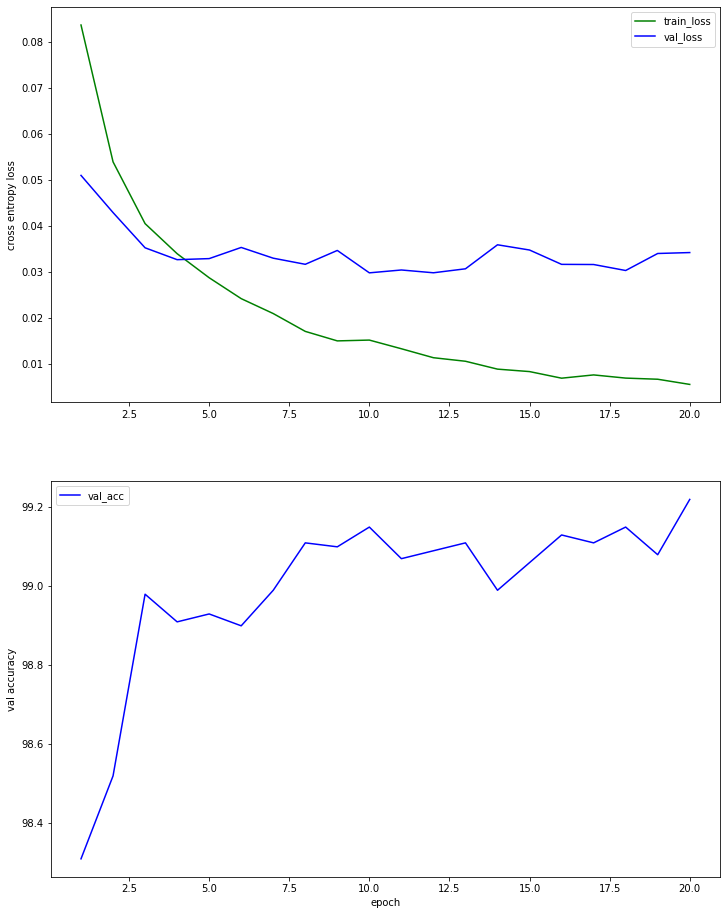

In [10]:
# Plot losses and metrics
fig, axs = plt.subplots(2, 1, figsize=(12, 16))
axs[1].set_xlabel('epoch')
axs[0].set_ylabel('cross entropy loss')
axs[1].set_ylabel('val accuracy')
x_epoch = list(range(1, len(train_losses) + 1))
axs[0].plot(x_epoch, train_losses, c='g', label='train_loss')
axs[0].plot(x_epoch, val_losses, c='b', label='val_loss')
axs[1].plot(x_epoch, val_accuracies, c='b', label='val_acc')
axs[0].legend(loc='best')
axs[1].legend(loc='best')
plt.show()

# Visualize some results

In [11]:
# Find one correctly classified and one misclassified
found_bad = False
found_good = False
bad_example = None
good_example = None

with torch.no_grad():
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        outputs = net(data)
        pred = outputs.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        
        for i in range (0, len(target)):
            if not found_good and target[i] == pred[i]:
                good_example = transforms.ToPILImage()(data[i].cpu()), target[i].cpu().numpy(), pred[i][0].cpu().numpy()
                found_good = True
            if not found_bad and target[i] != pred[i]:
                bad_example = transforms.ToPILImage()(data[i].cpu()), target[i].cpu().numpy(), pred[i][0].cpu().numpy()
                found_bad = True
        
        if found_bad and found_good:
            break

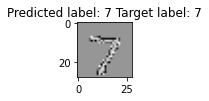

In [12]:
img, target_label, pred_label = good_example

# Note: Images look strange because they are still normalized. Denormalize them
# to get the original looking images.
fig = plt.figure(figsize=(1,1))
ax1 = fig.add_subplot(1,1,1)
plt.title("Predicted label: " + str(pred_label) + " Target label: " + str(target_label))
ax1.imshow(img, cmap="gray")

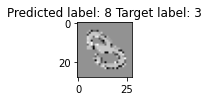

In [13]:
img, target_label, pred_label = bad_example

fig = plt.figure(figsize=(1,1))
ax1 = fig.add_subplot(1,1,1)
plt.title("Predicted label: " + str(pred_label) + " Target label: " + str(target_label))
ax1.imshow(img, cmap="gray")